In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

In [5]:
X,y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

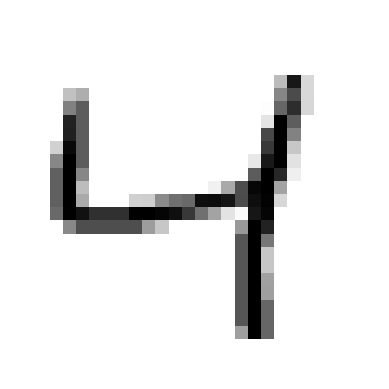

'4'

In [6]:
#images are in 28 by 28 array with intensity 0 to 255
import matplotlib.pyplot as plt

def plot_digits(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[2]
plot_digits(some_digit)
plt.show()
y[2]

In [21]:
y[:20]

array(['5', '0', '4', '1', '9', '2', '1', '3', '1', '4', '3', '5', '3',
       '6', '1', '7', '2', '8', '6', '9'], dtype=object)

In [7]:
#its already split 60k train 10k test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
#Train a binary classifier 5 or not 5
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [23]:
#measuring cross val score
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [24]:
#instead of accuracy as it can be skewed for skewed datasets we use confusion matrix
#cross_val_predict returns the predictions not the accuracy
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [26]:
from sklearn.metrics import confusion_matrix, recall_score
cm = confusion_matrix(y_train_5, y_train_pred)
recall_score = recall_score(y_train_5, y_train_pred)
recall_score

0.6511713705958311

In [27]:
#f1 is harmonic mean of precision and reacall f1 is high if both are high
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [30]:
#decision_function() returns a score for each instance distance from decision boundary
#you can set your own threshold
y_scores = sgd_clf.decision_function([X[0]])
threshold = 0
y_some_digit_pred = (y_scores>threshold)
print(y_scores, y_some_digit_pred)

[2164.22030239] [ True]


If we raise the threshold to 3000 it will increase precision but decrease recall

In [31]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [33]:
#precision_recall_curve finction compute precisoin and recall for all possible 
#threshold last precision 0 and last recall =1 leading to infinity
from sklearn.metrics import precision_recall_curve

precisions, recalls, threshold = precision_recall_curve(y_train_5, y_scores)
print(precisions, recalls, threshold)

[0.09035    0.09035151 0.09035301 ... 1.         1.         1.        ] [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 3.68935621e-04
 1.84467810e-04 0.00000000e+00] [-146348.56726174 -142300.00705404 -137588.97581744 ...   38871.26391927
   42216.05562787   49441.43765905]


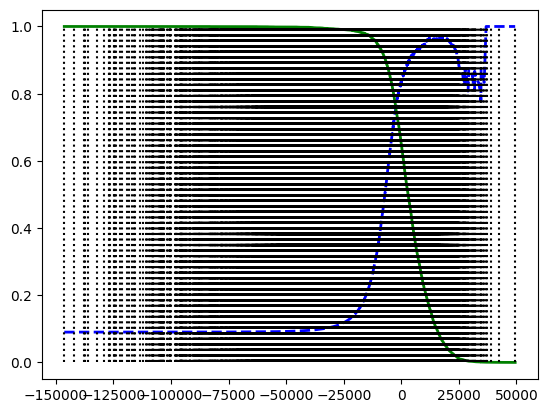

In [34]:
plt.plot(threshold, precisions[:-1], "b--", label="Precision",
linewidth=2)
plt.plot(threshold, recalls[:-1], "g-", label="Recall",
linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

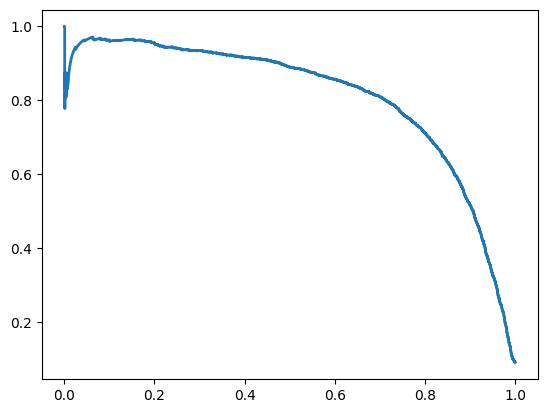

In [35]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.show

In [36]:
idx_for_90_precision = (precisions >= 0.90).argmax()
#argmax returns index where precision in precision array is more that 0.90
threshold_for_90_precision = threshold[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991441826)

In [37]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [38]:
from sklearn.metrics import precision_score
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [39]:
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

In [40]:
idx_for_threshold_at_90 = (threshold <=threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90],
fpr[idx_for_threshold_at_90]
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.show()

ValueError: not enough values to unpack (expected 2, got 1)